In [98]:
import os
import torch

# CODE FILES HERE
from models.tdcvae.tdcvae import Encoder, Decoder, TD_Cvae, PATH
from solver import Solver
from dataloader import DataLoader
from preprocessing import Preprocessing
from plot import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space, plot_latent_space_no_labels, \
plot_latent_manifold, plot_faces_grid, plot_faces_samples_grid, plot_y_space

# SETTINGS HERE
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # to see the CUDA stack
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [100]:
# Choose the dataset and tune hyperparameters here!
dataset = "MNIST"

batch_size = 128
optimizer = torch.optim.Adam
T = 2

if dataset == "MNIST":
    epochs = 16
    hidden_dim = 500
    z_dim = 2
    warmup_epochs = 0
    beta = 1 if z_dim == 2 else 1
    step_lr = False
    step_config = {
        "step_size" : 200,
        "gamma" : 0.1 # or 0.75
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": 1e-4
    }
    thetas = {
        "theta_1": [-180, 180],
        "theta_2": [-30, 30] # +theta_1
    }

In [89]:
data_loader = DataLoader(PATH, batch_size, dataset, z_dim)
prepro = Preprocessing(thetas)
model = TD_Cvae(data_loader.input_dim, hidden_dim, z_dim, T)

for batch_idx, data in enumerate(self.solver.data_loader.test_loader):
    print(data)

In [41]:
solver = Solver(model, data_loader, optimizer, z_dim, epochs, step_lr, step_config, optim_config, warmup_epochs, beta, tdcvae_mode=True, prepro=prepro)
solver.main()

+++++ START RUN +++++
====> Epoch: 1 train set loss avg: 478.2562
====> Test set loss avg: 419.7927
65.94456028938293 seconds for epoch 1
====> Epoch: 2 train set loss avg: 379.0117
====> Test set loss avg: 344.3176
69.93172454833984 seconds for epoch 2
====> Epoch: 3 train set loss avg: 317.6119
====> Test set loss avg: 296.9448
78.78526306152344 seconds for epoch 3
====> Epoch: 4 train set loss avg: 277.4918
====> Test set loss avg: 265.0946
83.57454013824463 seconds for epoch 4
====> Epoch: 5 train set loss avg: 248.3123
====> Test set loss avg: 245.1244
85.93716025352478 seconds for epoch 5
====> Epoch: 6 train set loss avg: 227.5662
====> Test set loss avg: 232.5093
84.45098328590393 seconds for epoch 6
====> Epoch: 7 train set loss avg: 212.9675
====> Test set loss avg: 222.0592
89.69562864303589 seconds for epoch 7
====> Epoch: 8 train set loss avg: 200.7712
====> Test set loss avg: 219.0507
94.09710836410522 seconds for epoch 8
====> Epoch: 9 train set loss avg: 191.3363
====> 

In [ ]:
# Insert name of model here if want to load a model, e.g. solver.save_model_dir + "/VAE_MNIST_train_loss=151.39_z=2.pt"
#solver = torch.load(solver.save_model_dir + "/VAE_MNIST_train_loss=97.15_z=20.pt")
#solver.model.eval()

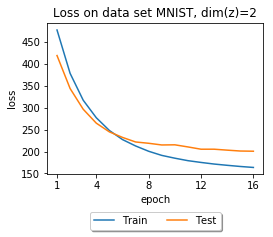

In [90]:
# Plotting train and test losses for all epochs
plot_losses(solver, 4)

epoch: 1, mu(z): -0.0003, stddev(z): 1.0658, var(z): 1.1359, var(mu(z)): 0.4305 E[var(q(z|x)]: 0.7474
epoch: 4, mu(z): 0.0009, stddev(z): 1.1619, var(z): 1.3500, var(mu(z)): 1.5308 E[var(q(z|x)]: 0.0593
epoch: 8, mu(z): 0.0003, stddev(z): 1.3434, var(z): 1.8048, var(mu(z)): 2.0042 E[var(q(z|x)]: 0.0475
epoch: 16, mu(z): -0.0005, stddev(z): 1.4527, var(z): 2.1103, var(mu(z)): 2.2890 E[var(q(z|x)]: 0.0388


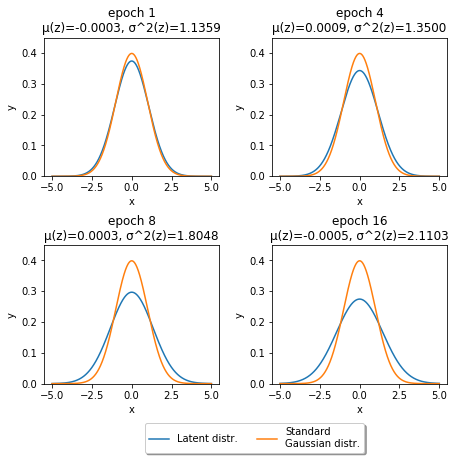

In [91]:
plot_gaussian_distributions(solver)

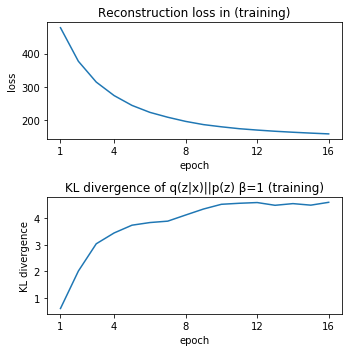

In [92]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 0
if DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
                             solver.train_loss_history["train_loss_acc"], \
                             solver.test_loss_history, \
                             solver.train_loss_history["recon_loss_acc"], \
                             solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
        print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
plot_rl_kl(solver, 4)

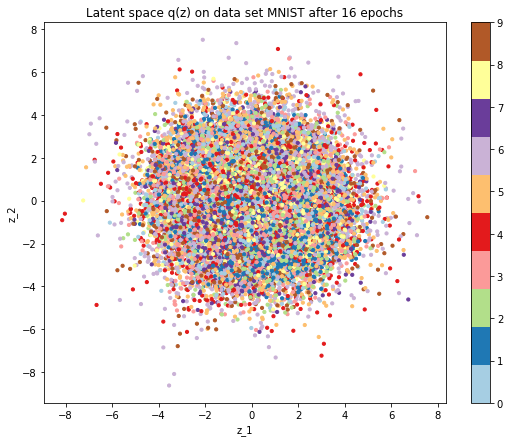

In [93]:
# visualize q(z) (latent space z)
if solver.z_dim == 2:
    plot_latent_space(solver)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

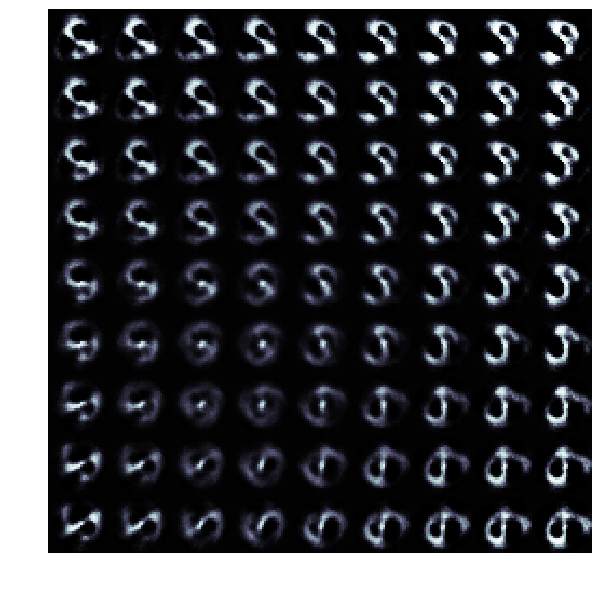

In [107]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if solver.z_dim == 2:
    n = 9
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)
    plot_latent_manifold(solver, "bone", grid_x, grid_y, n)
else:
    print("Plot is not possible as dimension of z is not 2")

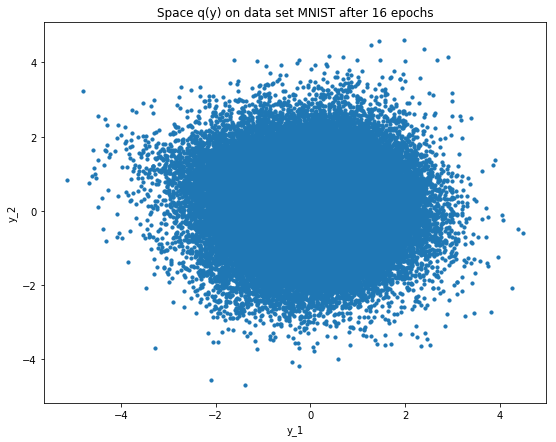

In [95]:
if solver.z_dim == 2:
    plot_y_space(solver)
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [97]:
last_train_loss = solver.train_loss_history["train_loss_acc"][-1]
torch.save(solver, solver.save_model_dir + "/Temporal_" + solver.data_loader.dataset + "_train_loss=" + "{0:.2f}".format(last_train_loss) + "_z=" + str(solver.z_dim) + ".pt")

PicklingError: Can't pickle <class 'solver.Solver'>: it's not the same object as solver.Solver